In [101]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
import astropy.units as u
import pandas as pd

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from src import GlobularCluster
from src.plot import LogNorm, AsinhNorm
from src.utils import profile_binning, clip_quantile_nd
from src.cluster import DBSCAN_Clustering

from src.plot import colorbar_non_mappable

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Analytic sigma profile

In [102]:
def sigmar_2(x, M_gc, r_scale, beta):
    sig2 = -(M_gc
            * (
                - 6 * beta
                - 36 * x ** 2 * beta
                - 70 * x ** 4 * beta
                - 56 * x ** 6 * beta
                - 16 * x ** 8 * beta
                + 48 * x ** 3 * np.sqrt(1 + x ** 2) * beta
                + 48 * x ** 5 * np.sqrt(1 + x ** 2) * beta
                + 16 * x ** 7 * np.sqrt(1 + x ** 2) * beta
                + x * np.sqrt(1 + x ** 2) * (-1 + 16 * beta)
            )
        ) / (6.0 * r_scale * x * (1 + x ** 2))  # r_scale in pc

    return constants.G * u.solMass * sig2 / u.pc

Generate realistic mock normalized data

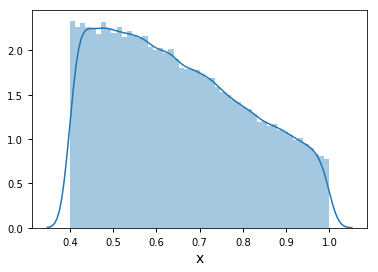

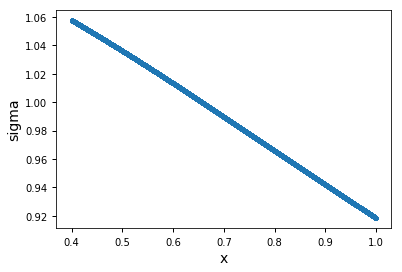

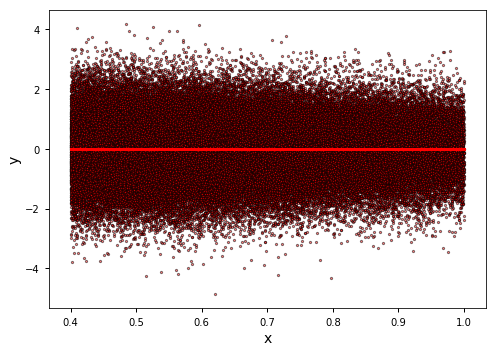

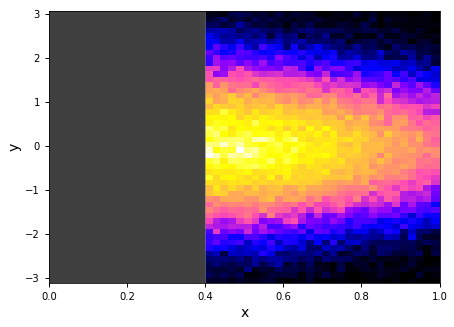

In [157]:
# parameter of GC
M_gc = 1e6
r_scale = 24
beta = 0.002 # ratio of M_BH
y_mean = 0  # mean pm

# generate mock r (normed)
x = stats.truncnorm(loc=0.4, scale=0.4, a=0, b=1.5).rvs(100000)
sig = np.sqrt(sigmar_2(x, M_gc, r_scale, beta)).to_value(u.km/u.s)

# normalize sigma
sig_n = np.sqrt(sigmar_2(1, M_gc, r_scale, beta)).to_value(u.km/u.s)
# sig = sig/sig_n

# generate mock pm (normed)
X = x[:, np.newaxis]
y0 = y_mean + rng.normal(0, sig, X.shape[0])

# normalize by std of data
scale = y0.std()
y = y0 / scale

# distribution in x
sns.distplot(x)
plt.xlabel("x")
plt.show()

# sigma profile
plt.plot(x, sig / scale, '.')
plt.xlabel("x")
plt.ylabel("sigma")
plt.show()

# display x-y scatter 
plt.figure(figsize=(7,5))
X_ = np.linspace(x.min(), x.max(), 100)
plt.scatter(X[:, 0], y, c='r', s=5, edgecolors=(0, 0, 0), alpha=0.5)
plt.plot(X_, y_mean*np.ones_like(X_), 'r', lw=3)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# display x-y hist2d
plt.figure(figsize=(7,5))
H, xb, yb, _ = plt.hist2d(x, y, bins=50, range=[[0,1.],np.quantile(y, [0.001, 0.999])], norm=AsinhNorm(), cmap="gnuplot2")

plt.axvspan(0, x.min(), 0, color="gray", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y") # normalized
plt.show()

Displaying impact from BH on sigma profile

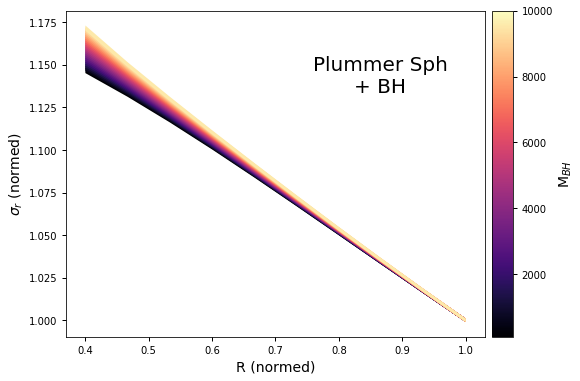

In [128]:
dist = 4.5e3 * u.pc
r_scale = 18.3 * u.arcmin.to(u.rad) * dist

R = np.linspace(0.4, 1, 10)

N_mod = 25
models = np.zeros((N_mod, len(R)))
f_BH_amp = np.linspace(1e-4,1e-2,N_mod)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_prop_cycle('color', plt.cm.magma(np.linspace(0,1,N_mod-1)))
for i, f_bh in enumerate(f_BH_amp[:-1]):
    sig2 = sigmar_2(R, M_gc, r_scale.value, f_bh)
    sig2_n = sigmar_2(1, M_gc, r_scale.value, f_bh)
    
    # normalize by sigma at R = 1
    mod = np.sqrt(sig2 / sig2_n)
    models[i] = mod
    
    if i>0:
        plt.fill_between(R, models[i-1]-0.001, mod+0.001, edgecolor="None")
        
plt.xlabel("R (normed)")
plt.ylabel("$\sigma_r$ (normed)")
plt.text(0.75,0.8,"Plummer Sph\n+ BH", fontsize=20,
         ha="center", va="center", transform=ax.transAxes)
        
ax = colorbar_non_mappable(fig, ax, vmin=f_BH_amp.min()*M_gc,vmax=f_BH_amp.max()*M_gc)

Take a look by binnng in r

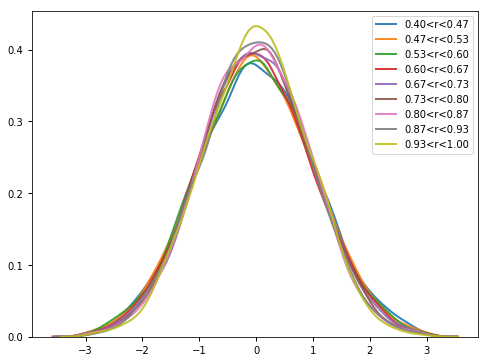

In [158]:
bins = np.linspace(x.min(), x.max(), 10)
r_rbin, z_rbin, z_bins = profile_binning(x, y, bins)

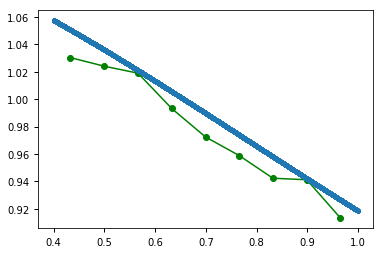

In [160]:
sigma_bins = np.array([np.std(z_bins[i]['pm']) for i in range(len(z_bins))])
plt.plot(r_rbin, sigma_bins, "g-o")
plt.plot(x, sig/scale, '.')

In [190]:
def prior(u, normalize=True):
    v = u.copy()
    
    v[0] = u[0] * 0.4 + 0.8  # M_GC
    
#     if normalize:
#         v[1] = u[1] * 0.4 + 0.8  # r_scale (normed)
#     else:
    v[1] = u[1] * 4 + 22     # r_scale
        
    v[2] = u[2] * 3 - 5      # log beta
    
    return v 

def loglike(v, normalize=True):
    M_gc, r_scale, logbeta = v
    
#     if normalize:    
    M_gc = M_gc * 1e6
        
    beta = 10**logbeta
    
    ypred = 0
    sigma2 = sigmar_2(x, M_gc, r_scale, beta).to_value((u.km/u.s)**2)
    
    if normalize:
#         sigma2_n = sigmar_2(1, M_gc, r_scale, beta).to_value((u.km/u.s)**2)
        sigma2 = sigma2 / scale**2
    
    residsq = (ypred - y)**2 / sigma2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma2))

    if not np.isfinite(loglike):
        loglike = -1e100

    return loglike

In [191]:
nlive_init=100
nlive_batch=25
maxbatch=2
pfrac=0.8

dlogz = 1e-3 * (nlive_init - 1) + 0.01

def get_params_fit(results, return_sample=False):
    samples = results.samples                                 # samples
    weights = np.exp(results.logwt - results.logz[-1])        # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)       # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)      # resample weighted samples
    pmed = np.median(samples_eq,axis=0)
    
    if return_sample:
        return pmed, pmean, pcov, samples_eq
    else:
        return pmed, pmean, pcov

### Normalized Fitting (normalized by std of data)

In [192]:
start = time.time()
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 3)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})
end = time.time()
print("Total Time Elapsed : %.1fs"%(end-start))

iter: 845 | batch: 2 | bound: 9 | nc: 120 | ncall: 5842 | eff(%): 14.464 | loglstar: -141731.241 < -141729.118 < -141729.999 | logz: -141733.255 +/-  0.257 | stop:  6.555                            

Total Time Elapsed : 247.1s


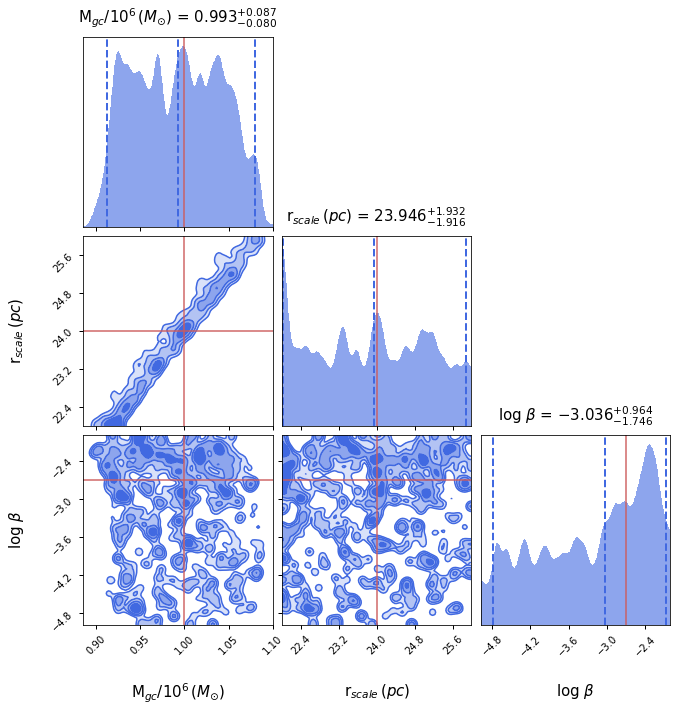

In [195]:
fig, ax = plt.subplots(3,3,figsize=(10,10))
dyplot.cornerplot(pdsampler.results, truths=[M_gc/1e6, r_scale, np.log10(beta)], labels=[r'M$_{gc}/10^6\,(M_{\odot})$', 'r$_{scale}\,(pc)$', r'log $\beta$'], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
plt.show()

### Normalized Fitting (normalized by $\sigma(r=1)$)  w/ arbitrary $M_{GC}$ and $r_{scale}$

In [148]:
start = time.time()
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 3)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})
end = time.time()
print("Total Time Elapsed : %.1fs"%(end-start))

iter: 494 | batch: 2 | bound: 0 | nc: 1 | ncall: 2672 | eff(%): 18.488 | loglstar: -150643.116 < -150640.675 < -150642.275 | logz: -150641.690 +/-  0.123 | stop:  6.895                              

Total Time Elapsed : 113.4s


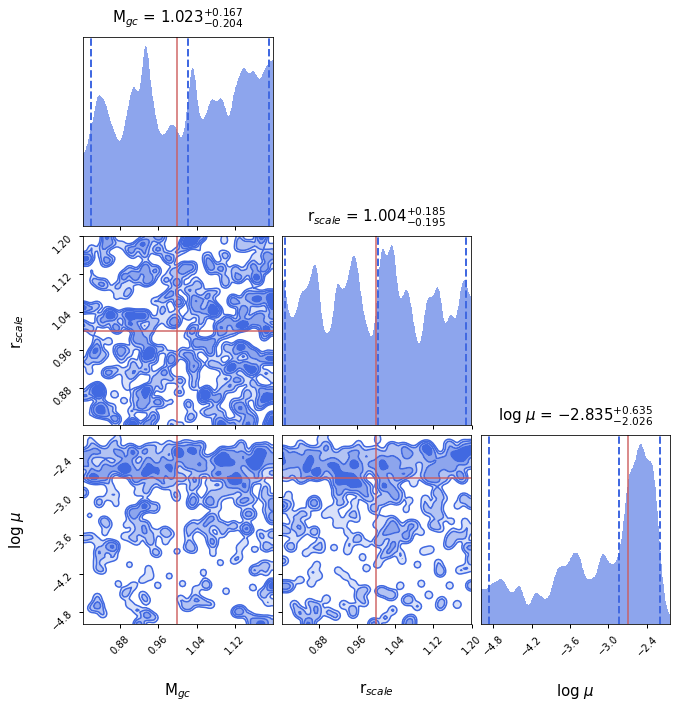

In [149]:
fig, ax = plt.subplots(3,3,figsize=(10,10))
dyplot.cornerplot(pdsampler.results, truths=[1, 1, np.log10(beta)], labels=[r'M$_{gc}$', 'r$_{scale}$', 'log $\mu$'], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
plt.show()

### Unnormalized Fitting w/ physical $M_{GC}$ and $r_{scale}$

In [115]:
start = time.time()
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 3)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})
end = time.time()
print("Total Time Elapsed : %.1fs"%(end-start))

iter: 872 | batch: 2 | bound: 11 | nc: 2 | ncall: 6201 | eff(%): 14.062 | loglstar: -303222.771 < -303220.475 < -303221.328 | logz: -303224.647 +/-  0.260 | stop:  5.649                             

Total Time Elapsed : 262.3s


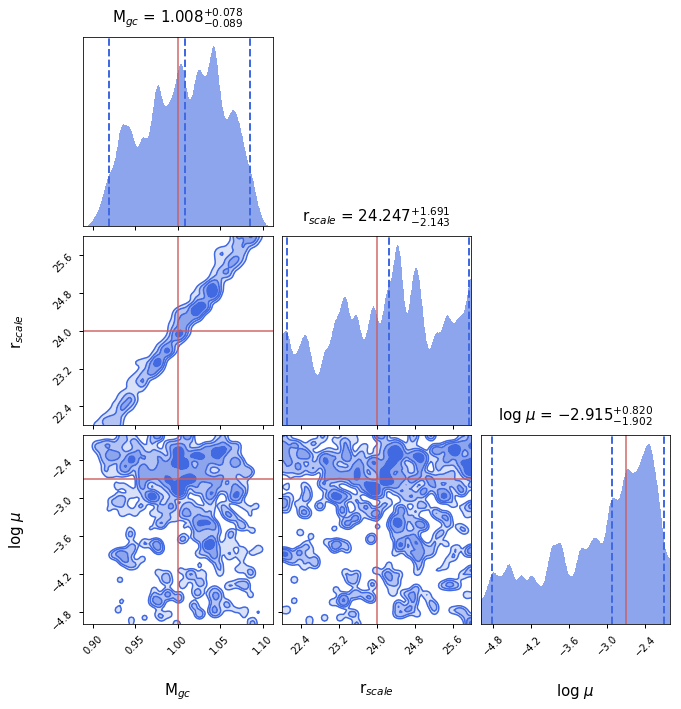

In [117]:
fig, ax = plt.subplots(3,3,figsize=(10,10))
dyplot.cornerplot(pdsampler.results, truths=[M_gc/1e6, r_scale, np.log10(beta)], labels=[r'M$_{gc}$', 'r$_{scale}$', 'log $\mu$'], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
plt.show()

Take a Look at real data radial distribution

In [223]:
drct = r"../data/"
gc_name = "NGC_104_47Tuc"

GC = GlobularCluster.from_directory(gc_name, drct)
GC.df.to_pandas().describe()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
count,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,90493.000000,72818.000000,90493.000000,90493.000000,90493.000000,90493.000000
mean,0.000156,-0.001003,5.069834,-2.391010,0.748230,0.620638,-0.075671,18.663277,0.902223,0.186291,0.172318,0.155831,5.962009
std,0.120260,0.120338,2.228220,1.715258,0.696715,0.602957,0.200438,1.435548,0.197522,0.389343,0.374415,0.068273,1.944638
min,-0.304802,-0.304871,-18.609150,-18.942380,0.023578,0.020528,-0.951285,10.600150,-1.243570,0.000000,0.000000,0.001046,0.014232
25%,-0.086928,-0.088950,4.563601,-2.982478,0.282561,0.232241,-0.184336,17.860400,0.791438,0.000000,0.000000,0.102253,5.270765
50%,-0.000863,-0.000408,5.225497,-2.455140,0.526232,0.425090,-0.070902,18.809510,0.873425,0.000000,0.000000,0.147533,5.875586
75%,0.087354,0.086612,5.831917,-1.870965,0.970185,0.772030,0.027872,19.691000,0.998234,0.000000,0.000000,0.206166,6.498322
max,0.304218,0.304813,19.767390,19.388680,5.227345,5.189505,0.982183,20.999230,4.339368,1.000000,0.998725,0.304992,19.986477


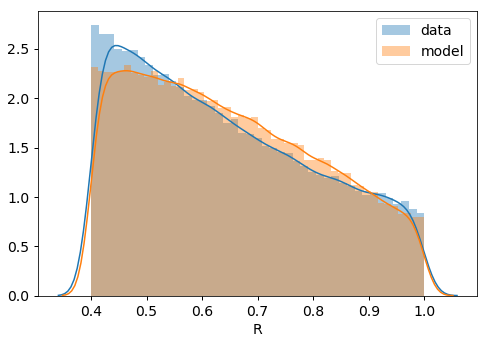

In [283]:
sns.distplot(GC.r[GC.r>0.4], label="data")
plt.xlabel("R")
sns.distplot(x, label="model")
plt.legend()
plt.tight_layout()
# plt.savefig("Tuc47_Model_r.png", png=50)
